<a href="https://colab.research.google.com/github/mactat/DL-IQIWA/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import random
from PIL import Image 
import copy

from torch import nn, Tensor
from torch.distributions import Distribution

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F

## Load Dataset ##

In [2]:

transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 1

# Train and validation
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(trainset, [train_size, test_size])

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

#Test
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Settings ##

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model ##

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1) # out: c x 16 x 16
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.upSample = nn.Upsample(size=(2,2))
        self.conv1 = nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        # x = self.upSample(x)
        # x = torch.sigmoid(self.conv2(x))
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Train ##


In [5]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (image_batch, _) in enumerate(train_dataloader):
        image_batch = image_batch.to(device)

        # Compute prediction error
        pred = model(image_batch)
        loss = loss_fn(pred, image_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10000 == 0:
            loss, current = loss.item(), batch * len(image_batch)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [6]:
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            pred = model(image_batch)
            test_loss += loss_fn(pred, image_batch).item()
    test_loss /= num_batches
    
    return test_loss

In [7]:
# Parameters for training
vae = VariationalAutoencoder()
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

learning_rate = 1e-3
num_epochs = 3

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

Number of parameters: 5675


In [8]:
val_loss_avg = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, vae, criterion, optimizer)
    val_loss = validate(validation_dataloader, vae, criterion)
    print(f"Test Error: \n Avg loss: {val_loss:>8f} \n")
    val_loss_avg.append(val_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.139612  [    0/50000]
loss: 0.003709  [10000/50000]
loss: 0.001878  [20000/50000]
loss: 0.002674  [30000/50000]
loss: 0.001406  [40000/50000]
Test Error: 
 Avg loss: 0.002136 

Epoch 2
-------------------------------
loss: 0.001368  [    0/50000]
loss: 0.000889  [10000/50000]
loss: 0.002392  [20000/50000]
loss: 0.001655  [30000/50000]
loss: 0.001903  [40000/50000]
Test Error: 
 Avg loss: 0.001909 

Epoch 3
-------------------------------
loss: 0.001346  [    0/50000]
loss: 0.001256  [10000/50000]
loss: 0.001817  [20000/50000]
loss: 0.004049  [30000/50000]
loss: 0.001655  [40000/50000]
Test Error: 
 Avg loss: 0.001928 

Done!


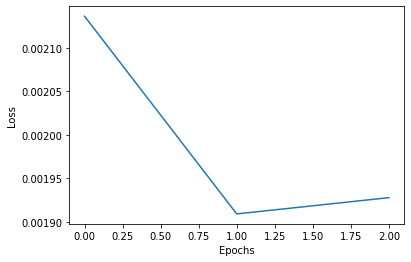

In [9]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(val_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluation

In [10]:
test_loss = validate(test_dataloader, vae, criterion)
print('average reconstruction error: %f' % (test_loss))

average reconstruction error: 0.001930


Original images


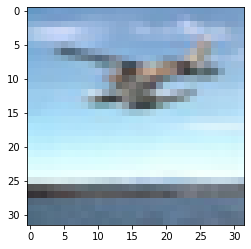

VAE reconstruction:


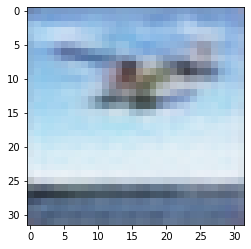

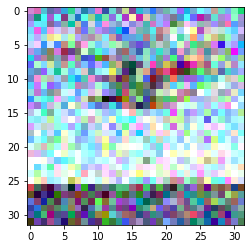

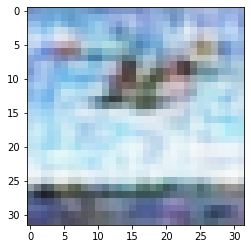

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image_tensor(img):
    img = torchvision.utils.make_grid(img,10,5)
    img = to_img(img)
    npimg = img.numpy()
    show_image_numpy(img)

def show_image_numpy(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images, 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image_tensor(images)

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

# noise
noise = np.random.normal(0, 0.2, images.numpy()[0].shape)
images = images + noise
show_image_tensor(images)

images = images.float()
visualise_output(images, vae)
